# Deep Learnign Final Project: Image Classification with PyTorch

## Overview
In this project, we design, train, and analyze Convolutional Neural Networks (CNNs) to classify images of bathroom environments (Toilet, No-Toilet, Not-Bathroom). This work builds upon a previous study conducted using the **fastai** library.

## Key Experiments
1.  **Training from Scratch:** We will design custom CNN architectures (Shallow vs. Deep) and analyze the impact of Batch Normalization and Regularization.
2.  **Transfer Learning (Feature Extraction):** We will pretrain a model on a proxy dataset (CIFAR-10) and transfer the weights to our specific domain.
3.  **Fine-Tuning ResNet50:** We will adapt an industry-standard ResNet50 model to push the limits of accuracy on our dataset.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os

# 1. Configuration
DATA_PATH = 'data'  # root folder containing the 3 class folders
BATCH_SIZE = 32
IMG_SIZE = 300     
VALID_SPLIT = 0.2   # 20% for validation
SEED = 42           # for reproducibility

# Normalization Constants 
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define Transforms
# We use Resize((h, w)) which squishes images by default, like FastAI's 'squish'
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # Standard normalization for stable training
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

# 3. Load Data & Split
try:
    full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=data_transforms)
    
    # Calculate split sizes
    val_size = int(len(full_dataset) * VALID_SPLIT)
    train_size = len(full_dataset) - val_size
    
    # Create the split using a generator for reproducibility
    generator = torch.Generator().manual_seed(SEED)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    class_names = full_dataset.classes
    print(f"Data loaded successfully!")
    print(f"Classes: {class_names}")
    print(f"Training images: {len(train_dataset)}")
    print(f"Validation images: {len(val_dataset)}")
    
except FileNotFoundError:
    print(f"Error: Could not find directory '{DATA_PATH}'. Check your path.")

Using device: cpu
Data loaded successfully!
Classes: ['no-toilet', 'not-bathroom', 'toilet']
Training images: 268
Validation images: 66


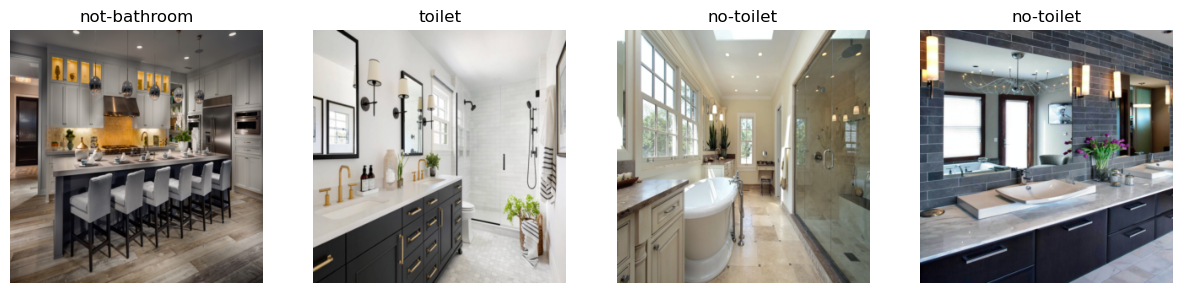

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Undo normalization for display
    mean = np.array(NORM_MEAN)
    std = np.array(NORM_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch (showing first 4 images)
plt.figure(figsize=(15, 5))
for i in range(min(4, len(inputs))):
    plt.subplot(1, 4, i+1)
    imshow(inputs[i], title=class_names[classes[i]])
plt.show()

## The training function

In [5]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Deep copy the model if it's the best one so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### We will compare 2 models:
Lets explort two distinct architectures to investigate the impact of depth on feature extraction capabilities:

1.The Shallow Model (SimpleCNN): Consists of only two convolutional blocks. With fewer layersit focuses primarily on low-level features like edges, color blobs, and simple textures. It lacks the hierarchical capacity to assemble these simple features into complex object parts (like a toilet bowl shape).

In [8]:
import torch.nn.functional as F

# 1. The Shallow Network (2 Conv Layers)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        # Block 1: 3 input channels (RGB) -> 16 output filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2: 16 -> 32 filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Adaptive Pool: Forces output to 1x1 per channel (size becomes 32 x 1 x 1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification Layer: 32 inputs -> 3 outputs (classes)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gap(x)
        x = x.flatten(1) # Flatten dimensions for linear layer
        x = self.fc(x)
        return x

2.The Deep Model (DeepCNN): Utilizes four convolutional blocks with increased filter counts (32 -> 256). This depth allows for hierarchical feature learning: early layers detect edges, middle layers detect shapes (curves, corners), and deeper layers detect semantic objects (bathroom fixtures).

In [10]:
# 2. The Deep Network (4 Conv Layers + More Filters)
class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Classification Head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.gap(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [11]:
# --- Experiment 1: Shallow CNN ---
print("Training Shallow CNN...")
model_shallow = SimpleCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
# Adam is usually faster to converge than SGD for simple tasks
optimizer_shallow = optim.Adam(model_shallow.parameters(), lr=0.001)

model_shallow, hist_shallow = train_model(model_shallow, criterion, optimizer_shallow, num_epochs=10)


# --- Experiment 2: Deep CNN ---
print("\nTraining Deep CNN...")
model_deep = DeepCNN(num_classes=len(class_names)).to(device)
optimizer_deep = optim.Adam(model_deep.parameters(), lr=0.001)

model_deep, hist_deep = train_model(model_deep, criterion, optimizer_deep, num_epochs=10)

Training Shallow CNN...
Epoch 1/10
----------
train Loss: 1.1071 Acc: 0.3321
val Loss: 1.0917 Acc: 0.3030
Epoch 2/10
----------
train Loss: 1.0963 Acc: 0.3582
val Loss: 1.0942 Acc: 0.3030
Epoch 3/10
----------
train Loss: 1.0802 Acc: 0.3806
val Loss: 1.0876 Acc: 0.4545
Epoch 4/10
----------
train Loss: 1.0747 Acc: 0.4664
val Loss: 1.0848 Acc: 0.4545
Epoch 5/10
----------
train Loss: 1.0673 Acc: 0.4590
val Loss: 1.0853 Acc: 0.4545
Epoch 6/10
----------
train Loss: 1.0601 Acc: 0.4664
val Loss: 1.0873 Acc: 0.4545
Epoch 7/10
----------
train Loss: 1.0519 Acc: 0.4851
val Loss: 1.0887 Acc: 0.5152
Epoch 8/10
----------
train Loss: 1.0449 Acc: 0.5149
val Loss: 1.0946 Acc: 0.4697
Epoch 9/10
----------
train Loss: 1.0368 Acc: 0.5075
val Loss: 1.0955 Acc: 0.4848
Epoch 10/10
----------
train Loss: 1.0354 Acc: 0.4739
val Loss: 1.1051 Acc: 0.4242

Training complete in 4m 12s
Best Val Acc: 0.5152

Training Deep CNN...
Epoch 1/10
----------
train Loss: 1.0844 Acc: 0.3694
val Loss: 1.0927 Acc: 0.3636
E

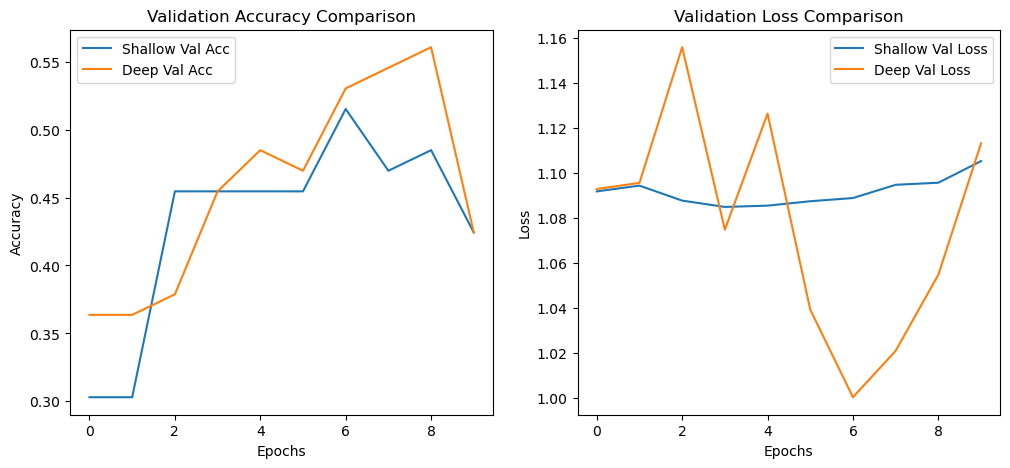

In [12]:
def plot_comparison(hist1, name1, hist2, name2):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist1['val_acc'], label=f'{name1} Val Acc')
    plt.plot(hist2['val_acc'], label=f'{name2} Val Acc')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist1['val_loss'], label=f'{name1} Val Loss')
    plt.plot(hist2['val_loss'], label=f'{name2} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_comparison(hist_shallow, "Shallow", hist_deep, "Deep")

As expected the DeepCNN architecture performed better, however absolute accuracy remains suboptimal in both models, we can also see that deep model's loss graph is instable. We can see spikes in loss which means it constantly learns and forgets features between epochs. Let's experiment with hyperparameters and optimization algorithms to see how it impacts accuracy.  
It is important to mention that these models would probably perform better if we added more data, but as we will see later the amount we have is enough for smarter models.  
First I increased the amount of epochs a little as I saw the iprovements were still sometimes significants in the later epochs, while also not having too much of them to retain reasonable training time. 

In [14]:
experiments = {}  # Dictionary to store all results
NUM_EPOCHS = 12

print("STARTING EXPERIMENT")
print("="*30)

# ==========================================
# ROUND 1: SimpleCNN (The Shallow Model)
# ==========================================

# 1. SimpleCNN + Adam
print("\nRUN 1: SimpleCNN + Adam (lr=0.001)")
model = SimpleCNN(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
_, experiments['Shallow_Adam'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

# 2. SimpleCNN + SGD
print("\nRUN 2: SimpleCNN + SGD (lr=0.01, momentum=0.9)")
model = SimpleCNN(num_classes=len(class_names)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
_, experiments['Shallow_SGD'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)


# ==========================================
# ROUND 2: DeepCNN (The Deep Model)
# ==========================================

# 3. DeepCNN + Adam
print("\nRUN 3: DeepCNN + Adam (lr=0.001)")
model = DeepCNN(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
_, experiments['Deep_Adam'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

# 4. DeepCNN + SGD
print("\nRUN 4: DeepCNN + SGD (lr=0.01, momentum=0.9)")
model = DeepCNN(num_classes=len(class_names)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
_, experiments['Deep_SGD'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

print("\nAll Experiments Complete!")

STARTING EXPERIMENT

RUN 1: SimpleCNN + Adam (lr=0.001)
Epoch 1/12
----------
train Loss: 1.1154 Acc: 0.2948
val Loss: 1.0987 Acc: 0.3333
Epoch 2/12
----------
train Loss: 1.0835 Acc: 0.4030
val Loss: 1.1050 Acc: 0.4242
Epoch 3/12
----------
train Loss: 1.0738 Acc: 0.4440
val Loss: 1.1058 Acc: 0.4394
Epoch 4/12
----------
train Loss: 1.0701 Acc: 0.4627
val Loss: 1.1120 Acc: 0.4697
Epoch 5/12
----------
train Loss: 1.0661 Acc: 0.4739
val Loss: 1.1039 Acc: 0.4242
Epoch 6/12
----------
train Loss: 1.0622 Acc: 0.4590
val Loss: 1.1050 Acc: 0.4394
Epoch 7/12
----------
train Loss: 1.0564 Acc: 0.4478
val Loss: 1.1081 Acc: 0.4394
Epoch 8/12
----------
train Loss: 1.0522 Acc: 0.4366
val Loss: 1.1100 Acc: 0.4394
Epoch 9/12
----------
train Loss: 1.0486 Acc: 0.4590
val Loss: 1.1182 Acc: 0.4394
Epoch 10/12
----------
train Loss: 1.0447 Acc: 0.4552
val Loss: 1.1148 Acc: 0.4242
Epoch 11/12
----------
train Loss: 1.0440 Acc: 0.4142
val Loss: 1.1104 Acc: 0.4394
Epoch 12/12
----------
train Loss: 1.037

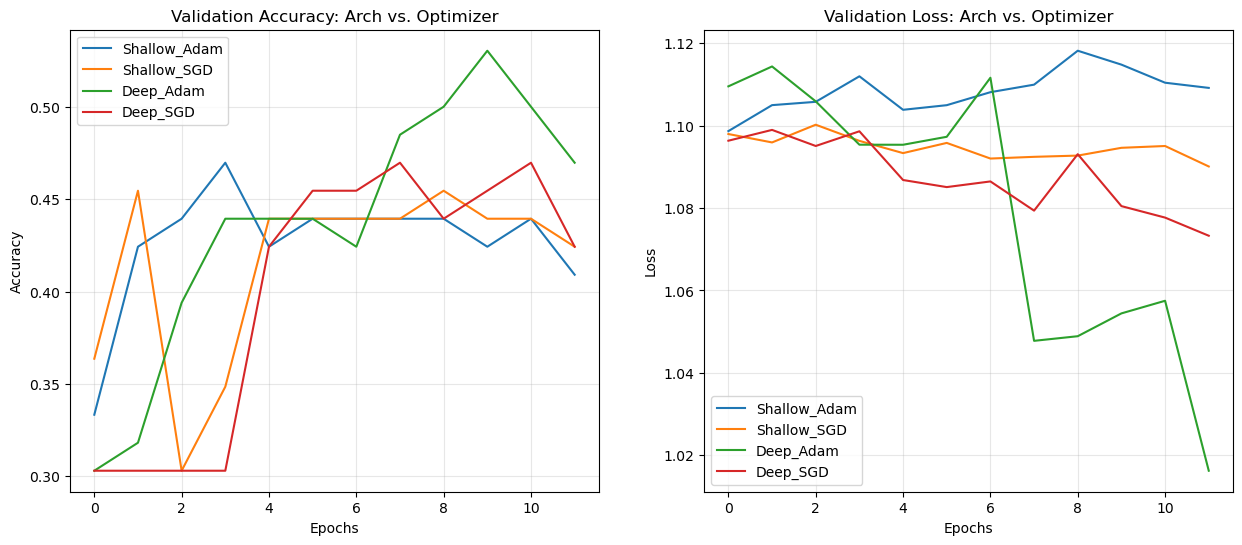

In [15]:
plt.figure(figsize=(15, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
for name, hist in experiments.items():
    plt.plot(hist['val_acc'], label=name)
plt.title('Validation Accuracy: Arch vs. Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
for name, hist in experiments.items():
    plt.plot(hist['val_loss'], label=name)
plt.title('Validation Loss: Arch vs. Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Our analysis identifies the Deep CNN trained with Adam as the clear winner, achieving a peak validation accuracy of approximately 54% (up to 60% on different runs), outperforming the Shallow architecture models which stayed near 40%. This performance gap confirms that the problems complexity requires a deeper hierarchical structure to effectively extract semantic features (such as "toilet" vs. "sink") rather than just low-level edges.

However, the validation loss curve for the Deep/Adam model is still super unstable. You can see the 'jaggedness' in the green loss line, it bounces around a lot, which means the model is learning fast but oscillating and likely overfitting to specific batches. This instability gives us the perfect motivation for the next phase: adding Batch Normalization to smooth things out and Regularization to help it generalize.

We will save this model as the baseline to not retrain every time.

In [18]:
import os

BASELINE_FILENAME = 'deep_cnn_baseline.pth'
BASELINE_LR = 0.001
BASELINE_EPOCHS = 12

def load_saved_model(filename):
    """Loads weights into a new DeepCNN instance."""
    model = DeepCNN(num_classes=len(class_names)).to(device)
    # Load the weights
    model.load_state_dict(torch.load(filename))
    model.eval() # Set to evaluation mode by default
    return model

def train_and_save_baseline():
    """Trains a fresh DeepCNN and saves it."""
    print("No saved model found. Training Baseline from scratch...")
    
    model = DeepCNN(num_classes=len(class_names)).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=BASELINE_LR)
    
    model, history = train_model(model, criterion, optimizer, num_epochs=BASELINE_EPOCHS)
    
    torch.save(model.state_dict(), BASELINE_FILENAME)
    print(f"Training done. Model saved to '{BASELINE_FILENAME}'")
    return model

# Lazy Loading of the model
if os.path.exists(BASELINE_FILENAME):
    print(f"Found file '{BASELINE_FILENAME}'. Loading...")
    model_baseline = load_saved_model(BASELINE_FILENAME)
    print("Model loaded successfully! Ready for use.")
else:
    model_baseline = train_and_save_baseline()

No saved model found. Training Baseline from scratch...
Epoch 1/12
----------
train Loss: 1.1189 Acc: 0.3470
val Loss: 1.0934 Acc: 0.3182
Epoch 2/12
----------
train Loss: 1.0849 Acc: 0.3657
val Loss: 1.0952 Acc: 0.3030
Epoch 3/12
----------
train Loss: 1.0583 Acc: 0.4030
val Loss: 1.0951 Acc: 0.3636
Epoch 4/12
----------
train Loss: 1.0343 Acc: 0.4552
val Loss: 1.0906 Acc: 0.4848
Epoch 5/12
----------
train Loss: 0.9928 Acc: 0.5112
val Loss: 1.1290 Acc: 0.4697
Epoch 6/12
----------
train Loss: 0.9642 Acc: 0.5187
val Loss: 1.0287 Acc: 0.4848
Epoch 7/12
----------
train Loss: 0.9468 Acc: 0.5336
val Loss: 1.0921 Acc: 0.4848
Epoch 8/12
----------
train Loss: 0.9326 Acc: 0.5522
val Loss: 1.0476 Acc: 0.4697
Epoch 9/12
----------
train Loss: 0.9152 Acc: 0.5410
val Loss: 1.0380 Acc: 0.5152
Epoch 10/12
----------
train Loss: 1.0570 Acc: 0.5187
val Loss: 1.0741 Acc: 0.4242
Epoch 11/12
----------
train Loss: 0.9761 Acc: 0.4925
val Loss: 1.0118 Acc: 0.5606
Epoch 12/12
----------
train Loss: 0.945

### Adding Batch normalization

In [20]:
class DeepCNN_BN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN_BN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)   # Batch Norm
        self.pool = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)   # Batch Norm
        
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # <--- Added Batch Norm
        
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # <--- Added Batch Norm
        
        # Head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # Order: Conv -> BN -> ReLU -> Pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = self.gap(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

Training Deep CNN + Batch Norm ...
Epoch 1/12
----------
train Loss: 0.9634 Acc: 0.5634
val Loss: 1.3231 Acc: 0.3636
Epoch 2/12
----------
train Loss: 0.9041 Acc: 0.5709
val Loss: 1.3450 Acc: 0.3333
Epoch 3/12
----------
train Loss: 0.8666 Acc: 0.6157
val Loss: 1.2806 Acc: 0.3788
Epoch 4/12
----------
train Loss: 0.8335 Acc: 0.6231
val Loss: 1.1461 Acc: 0.4242
Epoch 5/12
----------
train Loss: 0.8251 Acc: 0.6306
val Loss: 0.8931 Acc: 0.5303
Epoch 6/12
----------
train Loss: 0.8102 Acc: 0.6343
val Loss: 1.0193 Acc: 0.5152
Epoch 7/12
----------
train Loss: 0.7983 Acc: 0.6679
val Loss: 0.9324 Acc: 0.5909
Epoch 8/12
----------
train Loss: 0.8574 Acc: 0.6231
val Loss: 1.1167 Acc: 0.5152
Epoch 9/12
----------
train Loss: 0.8295 Acc: 0.6455
val Loss: 1.0175 Acc: 0.4394
Epoch 10/12
----------
train Loss: 0.7914 Acc: 0.6493
val Loss: 0.9676 Acc: 0.5909
Epoch 11/12
----------
train Loss: 0.7567 Acc: 0.6940
val Loss: 0.9392 Acc: 0.5303
Epoch 12/12
----------
train Loss: 0.7224 Acc: 0.6940
val Los

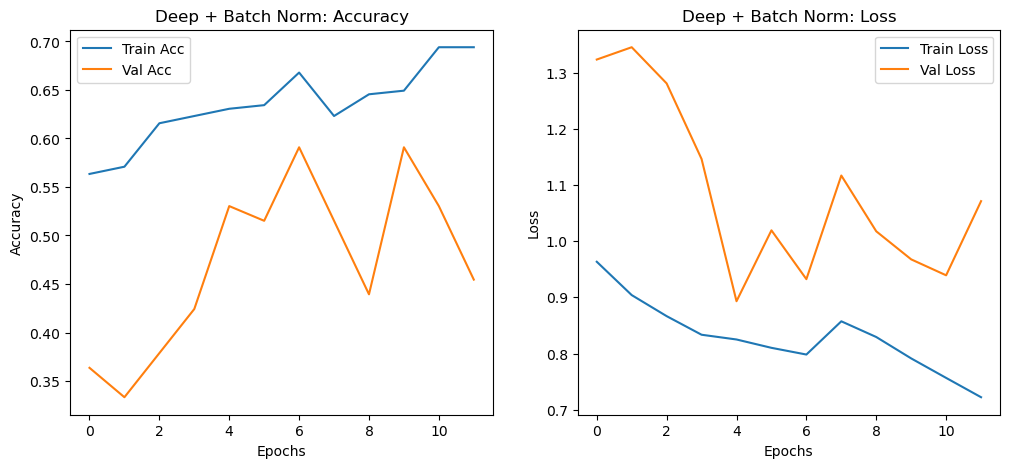

In [21]:
# 1. Train Deep BN
BN_FILENAME = 'deep_cnn_bn.pth'
print("Training Deep CNN + Batch Norm ...")
model_bn = DeepCNN_BN(num_classes=len(class_names)).to(device)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

model_bn, hist_bn = train_model(model_bn, criterion, optimizer_bn, num_epochs=12)

# 2. Save it
torch.save(model_bn.state_dict(), BN_FILENAME)
print("Model saved as " + BN_FILENAME)

# 3. Load Baseline History for Comparison
# Let's plot the BN training curve
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_bn['train_acc'], label='Train Acc')
plt.plot(hist_bn['val_acc'], label='Val Acc')
plt.title('Deep + Batch Norm: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(hist_bn['train_loss'], label='Train Loss')
plt.plot(hist_bn['val_loss'], label='Val Loss')
plt.title('Deep + Batch Norm: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Although Batch Normalization improved the accuracy over the baseline, the model still exhibits significant overfitting (Training Acc > Validation Acc) and instability. To fix this, we will apply Regularization.

### Adding Regularization

In [23]:
class DeepCNN_Reg(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN_Reg, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)  # Drop 50% of neurons
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = self.gap(x)
        x = x.flatten(1)
        
        x = self.dropout(x) #Apply Dropout
        
        x = self.fc(x)
        return x

In [31]:
# 1. Update Training Transforms (Augmentation)
# Note: Validation transforms stay simple
train_transforms_aug = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomRotation(15),           # Rotate +/- 15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Slight lighting changes
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

# Reload Train Loader
train_dataset.dataset.transform = train_transforms_aug
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print("Data Augmentation Enabled.")

# 2. Train and Save
REG_FILENAME = 'deep_cnn_regularized.pth'
print("\nTraining Final Regularized Model (Deep + BN + Dropout + Augmentation + L2)...")

model_reg = DeepCNN_Reg(num_classes=len(class_names)).to(device)

# weight_decay=1e-4 is the implementation of L2 Regularization
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=1e-4) 

model_reg, hist_reg = train_model(model_reg, criterion, optimizer_reg, num_epochs=20)

torch.save(model_reg.state_dict(), REG_FILENAME)
print("Model saved as " + REG_FILENAME)

Data Augmentation Enabled.

Training Final Regularized Model (Deep + BN + Dropout + Augmentation + L2)...
Epoch 1/20
----------
train Loss: 1.0061 Acc: 0.5187
val Loss: 1.0618 Acc: 0.3636
Epoch 2/20
----------
train Loss: 0.9664 Acc: 0.5634
val Loss: 1.3569 Acc: 0.3485
Epoch 3/20
----------
train Loss: 0.9417 Acc: 0.5336
val Loss: 1.3528 Acc: 0.3636
Epoch 4/20
----------
train Loss: 0.9523 Acc: 0.5485
val Loss: 1.1121 Acc: 0.4697
Epoch 5/20
----------
train Loss: 0.9284 Acc: 0.5709
val Loss: 0.9710 Acc: 0.5606
Epoch 6/20
----------
train Loss: 0.8760 Acc: 0.5821
val Loss: 0.9705 Acc: 0.5758
Epoch 7/20
----------
train Loss: 0.8887 Acc: 0.5597
val Loss: 1.0902 Acc: 0.5455
Epoch 8/20
----------
train Loss: 0.8665 Acc: 0.5933
val Loss: 0.9309 Acc: 0.5758
Epoch 9/20
----------
train Loss: 0.8614 Acc: 0.6082
val Loss: 1.0013 Acc: 0.5152
Epoch 10/20
----------
train Loss: 0.8576 Acc: 0.5672
val Loss: 0.9337 Acc: 0.5606
Epoch 11/20
----------
train Loss: 0.8475 Acc: 0.6418
val Loss: 0.9772 Ac

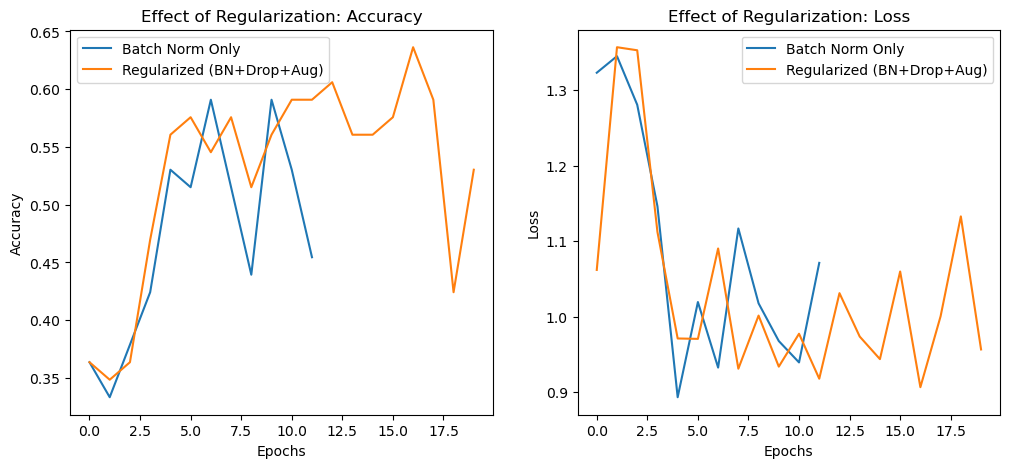

In [32]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
# Assuming 'hist_bn' is from the previous step
if 'hist_bn' in locals():
    plt.plot(hist_bn['val_acc'], label='Batch Norm Only')
plt.plot(hist_reg['val_acc'], label='Regularized (BN+Drop+Aug)')
plt.title('Effect of Regularization: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
if 'hist_bn' in locals():
    plt.plot(hist_bn['val_loss'], label='Batch Norm Only')
plt.plot(hist_reg['val_loss'], label='Regularized (BN+Drop+Aug)')
plt.title('Effect of Regularization: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We applied a set of regularization techniques: Batch Normalization to stabilize the learning inputs, Dropout (50%) and L2 Weight Decay to prevent over-reliance on specific neurons, and Data Augmentation (rotation, flips) to artificially expand the diversity of our training data.  
The application of regularization (Dropout + Augmentation + L2) successfully narrowed the generalization gap, bringing training and validation accuracy closer together and solving the overfitting that we saw before, with the model now peaking at 63% accuracy. However, the validation loss curve remains instable and 'spiky'. This persistent instability, despite heavy regularization, suggests that the dataset size (~300 images) is insufficient for a deep network to converge to a stable minimum from scratch. The model is forced to make large weight updates based on mini-batches, leading to the observed jumps in loss and accuracy. This confirms that Transfer Learning is not only an optimization, but a necessity for this specific problem.